<a href="https://colab.research.google.com/github/Platayo/Well-log-FluidType-Lithology-Prediction/blob/main/FYP_lithology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lasio
!pip install petrolib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 32.9 MB/s eta 0:00:00


###Load train and test dataset

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import lasio as las
import petrolib as plb

import random

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
## defining file paths
train_data_path = "drive/My Drive/exported_logs_ORIGINAL/train_wells"
test_data_path = "drive/MyDrive/exported_logs_ORIGINAL/test_wells"
Pearl_01 = f"{train_data_path}/pearl 01.las"
Pearl_02 = f"{train_data_path}/pearl 02.las"
Pearl_03 = f"{train_data_path}/pearl 03.las"
Pearl_04 = f"{train_data_path}/pearl 04.las"
Ataga_05 = f"{train_data_path}/ataga 05.las"
Ataga_07 = f"{train_data_path}/ataga 07.las"
Ataga_10 = f"{train_data_path}/ataga 10.las"
Ataga_11 = f"{train_data_path}/ataga 11.las"

#####Loading and reading Pearl wells

In [ ]:
## reading the las files
pearl_01 = las.read(Pearl_01)
pearl_02 = las.read(Pearl_02)
pearl_03 = las.read(Pearl_03)
pearl_04 = las.read(Pearl_04)

# convert las files to pandas dataframe
df_pearl_01 = pearl_01.df()
df_pearl_02 = pearl_02.df()
df_pearl_03 = pearl_03.df()
df_pearl_04 = pearl_04.df()

#drop unneeded logs
df_pearl_01 = df_pearl_01.drop(columns=["CALI","SONIC","FL","SW", "F","VSH","PHID","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF","FLUIDTYPES"])
df_pearl_02 = df_pearl_02.drop(columns=["CALI","SONIC","FL","SW", "F","VSH","PHID","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF","FLUIDTYPES"])
df_pearl_03 = df_pearl_03.drop(columns=["SONIC", "FL","SW", "F","VSH","PHID","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF","FLUIDTYPES"])
df_pearl_04 = df_pearl_04.drop(columns=["CALI","SONIC","FL","SW", "F","VSH","PHID","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF","FLUIDTYPES"])

# add a well name column
df_pearl_01.insert(0,'WELLNAME','Pearl 01')
df_pearl_02.insert(0,'WELLNAME','Pearl 02')
df_pearl_03.insert(0,'WELLNAME','Pearl 03')
df_pearl_04.insert(0,'WELLNAME','Pearl 04')

# concatenating all the wells together
Pearl = pd.concat([df_pearl_01,df_pearl_02, df_pearl_03, df_pearl_04 ], axis=0, ignore_index=False)


In [ ]:
Pearl

,WELLNAME,DENS,GR,NPHI,RES,LITHOLOGY
DEPT,,,,,,
898.94,Pearl 01,NaN,NaN,NaN,NaN,NaN
899.44,Pearl 01,NaN,NaN,NaN,NaN,NaN
899.94,Pearl 01,NaN,NaN,NaN,NaN,NaN
900.44,Pearl 01,NaN,NaN,NaN,NaN,NaN
900.94,Pearl 01,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
7990.50,Pearl 04,2.1802,100.891098,0.098601,1.5735,1.0
7991.00,Pearl 04,NaN,NaN,NaN,1.5735,NaN
7991.50,Pearl 04,NaN,NaN,NaN,1.5735,NaN


In [ ]:
Pearl.tail()

,WELLNAME,DENS,GR,NPHI,RES,LITHOLOGY
DEPT,,,,,,
7990.5,Pearl 04,2.1802,100.891098,0.098601,1.5735,1.0
7991.0,Pearl 04,NaN,NaN,NaN,1.5735,NaN
7991.5,Pearl 04,NaN,NaN,NaN,1.5735,NaN
7992.0,Pearl 04,NaN,NaN,NaN,1.5735,NaN
7992.5,Pearl 04,NaN,NaN,NaN,1.5735,NaN


#####Loading and reading Ataga wells

In [ ]:
## reading las files
ataga_05 = las.read(Ataga_05)
ataga_07 = las.read(Ataga_07)
ataga_10 = las.read(Ataga_10)
ataga_11 = las.read(Ataga_11)

# convert to pandas dataframe
df_ataga_05 = ataga_05.df()
df_ataga_07 = ataga_05.df()
df_ataga_10 = ataga_05.df()
df_ataga_11 = ataga_05.df()

# rename some log curves
df_ataga_05 = df_ataga_05.rename(columns={'RHOB':'DENS','ILD':'RES'})

df_ataga_07 = df_ataga_07.rename(columns={'RHOB':'DENS','ILD':'RES'})

df_ataga_10 = df_ataga_10.rename(columns={'RHOB':'DENS','ILD':'RES'})

df_ataga_11 = df_ataga_11.rename(columns={'RHOB':'DENS','ILD':'RES'})

## Drop unneeded logs
df_ataga_05 = df_ataga_05.drop(columns=["CALI","SP","DT","LLS","MSFL","FL","F","DEPT_1","VSH","PHID","SW","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF","FLUIDTYPES"])
df_ataga_07 = df_ataga_07.drop(columns=["CALI","SP","DT","LLS","MSFL","FL","F","DEPT_1","VSH","PHID","SW","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF","FLUIDTYPES"])
df_ataga_10 = df_ataga_10.drop(columns=["CALI","SP","DT","LLS","MSFL","FL","F","DEPT_1","VSH","PHID","SW","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF","FLUIDTYPES"])
df_ataga_11 = df_ataga_11.drop(columns=["CALI","SP","DT","LLS","MSFL","FL","F","DEPT_1","VSH","PHID","SW","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF","FLUIDTYPES"])

## insert well names
df_ataga_05.insert(0,"WELLNAME","Ataga 05")
df_ataga_07.insert(0,"WELLNAME","Ataga 07")
df_ataga_10.insert(0,"WELLNAME","Ataga 10")
df_ataga_11.insert(0,"WELLNAME","Ataga 11")

## concatenating the wells together
Ataga = pd.concat([df_ataga_05,df_ataga_07,df_ataga_10,df_ataga_11], axis=0, ignore_index=False)


In [ ]:
len(Ataga.columns), len(Pearl.columns)

(6, 6)

#####loading and reading Freeman wells

In [ ]:
## reading test dataset
freeman_03_st = f"{test_data_path}/freeman_003_st1.las"
freeman_05 = f"{test_data_path}/freeman_005.las"
freeman_01 = f"{test_data_path}/freeman_01.las"

Freeman_03_st = las.read(freeman_03_st)
Freeman_05 = las.read(freeman_05)
Freeman_01 = las.read(freeman_01)

## turn to pandas datframe
Freeman_03_st_df = Freeman_03_st.df()
Freeman_05_df = Freeman_05.df()
Freeman_01_df = Freeman_01.df()

## drop unneeded logs
Test_1 = Freeman_03_st_df.drop(columns=["FL","DT","VSH","PHID","SW","F","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF","FLUIDTYPES"])
Test_2 = Freeman_05_df.drop(columns=["FL","DT","VSH","PHID","SW","F","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF","FLUIDTYPES"])
Test_3 = Freeman_01_df.drop(columns=["FL","DT","VSH","PHID","SW","F","IGR","VSHF","NTG","SWIRR","PERM","PHIDF","PHIE","SWF","PERM_EFF","FLUIDTYPES"])

## Rename logs
Test_1 = Test_1.rename(columns= {'DEN':'DENS','NEU':'NPHI','LITHOLOGIES':'LITHOLOGY','RES_DEP':'RES'})
Test_2 = Test_2.rename(columns= {'DEN':'DENS','NEUT':'NPHI','LITHOLOGIES':'LITHOLOGY','RES_DEP':'RES'})
Test_3 = Test_3.rename(columns= {'DEN':'DENS','NEUT':'NPHI','LITHOLOGIES':'LITHOLOGY','RES_DEP':'RES'})

## insert well names
Test_1.insert(0,"WELLNAME","Freeman_03_st")
Test_2.insert(0,"WELLNAME","Freeman_05")
Test_3.insert(0,"WELLNAME","Freeman_01")


##Freeman 3st1

In [ ]:
# concatenate pearl, Ataga, Test_3, Test_2
train_data = pd.concat ((Pearl,Ataga,Test_2,Test_3))
train_data = train_data.reset_index()
Test_1 = Test_1.reset_index()

#####Preparing Validation dataset

In [ ]:
np.random.seed(42)


In [ ]:
# select two random wells from the 8 training wells for validation
valid_data = random.sample(list(train_data.WELLNAME.unique()),2)
print (valid_data)

['Pearl 01', 'Pearl 04']


In [ ]:
valid_data_list = []

for well in valid_data:
    well_data = train_data.loc[train_data.WELLNAME == well]
    valid_data_list.append(well_data)

validation_data = pd.concat(valid_data_list)


In [ ]:
validation_data.head()

,DEPT,WELLNAME,DENS,GR,NPHI,RES,LITHOLOGY
0,898.94,Pearl 01,NaN,NaN,NaN,NaN,NaN
1,899.44,Pearl 01,NaN,NaN,NaN,NaN,NaN
2,899.94,Pearl 01,NaN,NaN,NaN,NaN,NaN
3,900.44,Pearl 01,NaN,NaN,NaN,NaN,NaN
4,900.94,Pearl 01,NaN,NaN,NaN,NaN,NaN


In [ ]:
validation_data.tail()

,DEPT,WELLNAME,DENS,GR,NPHI,RES,LITHOLOGY
48160,7990.5,Pearl 04,2.1802,100.891098,0.098601,1.5735,1.0
48161,7991.0,Pearl 04,NaN,NaN,NaN,1.5735,NaN
48162,7991.5,Pearl 04,NaN,NaN,NaN,1.5735,NaN
48163,7992.0,Pearl 04,NaN,NaN,NaN,1.5735,NaN
48164,7992.5,Pearl 04,NaN,NaN,NaN,1.5735,NaN


In [ ]:
## separating the validation data into two wells

validation_data_1 = validation_data[validation_data.WELLNAME.isin([valid_data[0]])]
validation_data_2 = validation_data[validation_data.WELLNAME.isin([valid_data[1]])]

In [ ]:
validation_data_2.head()

,DEPT,WELLNAME,DENS,GR,NPHI,RES,LITHOLOGY
36959,2390.0,Pearl 04,1.6766,23.721600,0.408378,NaN,0.0
36960,2390.5,Pearl 04,1.6766,23.721600,0.408378,2000.0,0.0
36961,2391.0,Pearl 04,1.6766,26.095200,0.403776,2000.0,0.0
36962,2391.5,Pearl 04,1.7441,26.962799,0.410406,2000.0,0.0
36963,2392.0,Pearl 04,1.7822,25.871000,0.433983,2000.0,0.0


In [ ]:
new_train_data = pd.concat((train_data,validation_data_1,validation_data_2)).drop_duplicates(keep=False)
print(f'Previous train data shape: {train_data.shape}')
print(f'New train data shape: {new_train_data.shape}')

Previous train data shape: (159380, 7)
New train data shape: (131452, 7)


In [ ]:
# check for data leakage
print (f'Original train data rows: {train_data.shape[0]}')
print (f'New_train + Validation rows: {new_train_data.shape[0] + validation_data_1.shape[0] + validation_data_2.shape[0]}')

Original train data rows: 159380
New_train + Validation rows: 159380


#####Exploratory Data Analysis

In [ ]:
new_train_data.head()

,DEPT,WELLNAME,DENS,GR,NPHI,RES,LITHOLOGY
16722,2885.0,Pearl 02,NaN,NaN,NaN,2000.0,NaN
16723,2885.5,Pearl 02,NaN,45.143700,0.490197,2000.0,0.0
16724,2886.0,Pearl 02,NaN,45.143700,0.490197,2000.0,0.0
16725,2886.5,Pearl 02,1.5237,45.007801,0.523394,2000.0,0.0
16726,2887.0,Pearl 02,1.5237,44.992500,0.541535,2000.0,0.0


In [ ]:
new_train_data.tail(5)

,DEPT,WELLNAME,DENS,GR,NPHI,RES,LITHOLOGY
159375,13705.5,Freeman_01,2.1419,1.6927,0.471,NaN,0.0
159376,13706.0,Freeman_01,2.1419,1.6946,0.471,NaN,0.0
159377,13706.5,Freeman_01,2.1419,1.6966,0.471,NaN,0.0
159378,13707.0,Freeman_01,2.1419,1.6987,0.471,NaN,0.0
159379,13707.5,Freeman_01,2.1419,1.7008,0.471,NaN,NaN


In [ ]:
## number of fluid types
print(f'unique fluid type count: {len(dict(new_train_data.LITHOLOGY.value_counts()))}')

unique fluid type count: 2


In [ ]:
new_train_data.LITHOLOGY.value_counts() # 0-Sand, 1-Shale

1.0    97766
0.0    33064
Name: LITHOLOGY, dtype: int64

In [ ]:
train_well_items = dict(100-(new_train_data.isna().sum()/new_train_data.shape[0])*100)
train_well_items

{'DEPT': 100.0,
 'WELLNAME': 100.0,
 'DENS': 54.10872409700879,
 'GR': 99.52758421324894,
 'NPHI': 52.87557435413687,
 'RES': 96.26327480753432,
 'LITHOLOGY': 99.52682347929282}

In [ ]:
## selecting the dataset to be used for training
print("Percentage of values in test_1 logs:")
100 - Test_1.isna().sum()/Test_1.shape[0] * 100

Percentage of values in test_1 logs:


DEPT         100.000000
WELLNAME     100.000000
DENS          96.944242
GR            99.245191
NPHI          96.652057
RES           97.236426
LITHOLOGY     99.245191
dtype: float64

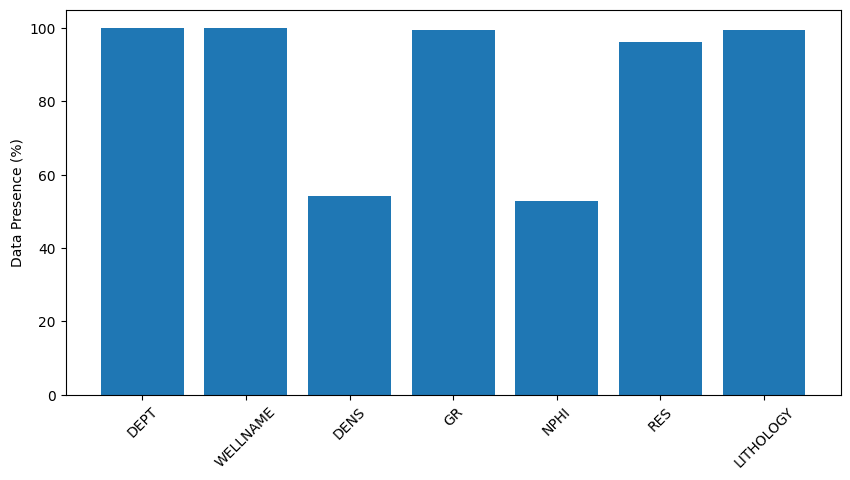

In [ ]:
occurences = np.zeros(len(train_well_items))
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.bar(x = np.arange(occurences.shape[0]),height=train_well_items.values())
ax.set_xticklabels(train_well_items.keys(),rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Data Presence (%)');

In [ ]:
lithology = dict(new_train_data.LITHOLOGY.value_counts())
lithology

{1.0: 97766, 0.0: 33064}

In [ ]:
86286/127453 * 100, 41167/127453 * 100

(67.70025028834159, 32.299749711658414)

In [ ]:
(list(lithology.values())[0] + list(lithology.values())[1])

130830

In [ ]:
lithology_names = ["Shale","Sand"]

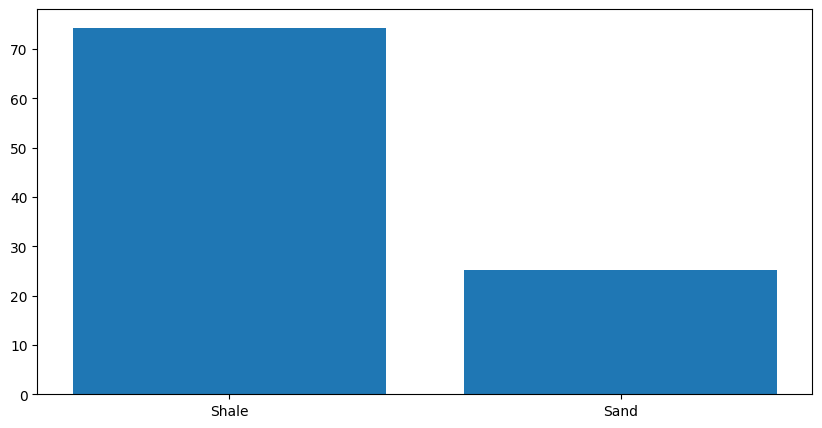

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.bar(lithology_names,(np.array(list(lithology.values()))/new_train_data.shape[0]*100));

####Data cleaning and Preparation

In [ ]:
# row numbers
ntrain = new_train_data.shape[0]
nval_1 = validation_data_1.shape[0]
nval_2 = validation_data_2.shape[0]
ntest_1 = Test_1.shape[0]

In [ ]:
new_train_data.shape

(131452, 7)

In [ ]:
## concatenating new_train_data, Test_1 and val_1,_2 for combined cleaning
df = pd.concat((new_train_data,Test_1,validation_data_1,validation_data_2)).reset_index(drop=True)

In [ ]:
df.shape

(167594, 7)

In [ ]:
## Drop rows where LITHOLOGY is NAN
df = df.dropna(subset=['LITHOLOGY'])

In [ ]:
# Test 1
count_missing_lithology = pd.isna(Test_1['LITHOLOGY']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")

Number of rows with missing values in LITHOLOGY: 62


In [ ]:
# Train_data
count_missing_lithology = pd.isna(new_train_data['LITHOLOGY']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")

Number of rows with missing values in LITHOLOGY: 622


In [ ]:
# validation 1
count_missing_lithology = pd.isna(validation_data_1['LITHOLOGY']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")

Number of rows with missing values in LITHOLOGY: 81


In [ ]:
# validation 2
count_missing_lithology = pd.isna(validation_data_2['LITHOLOGY']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")

Number of rows with missing values in LITHOLOGY: 4


In [ ]:
dropped_train = 622
dropped_test_1 = 62
dropped_val_1 = 81
dropped_val_2 = 4

In [ ]:
df.isna().sum()

DEPT             0
WELLNAME         0
DENS         60891
GR               0
NPHI         74352
RES           4573
LITHOLOGY        0
dtype: int64

In [ ]:
## calculate median of other numerical variables

#dens_median = df['DENS'].median()
#nphi_median = df['NPHI'].median()
#res_median = df['RES'].median()

In [ ]:
## replace missing values in numerical variables with -999

df['DENS'] = df['DENS'].fillna(-999)
df['NPHI'] = df['NPHI'].fillna(-999)
df['RES'] = df['RES'].fillna(-999)

In [ ]:
df.isna().sum()

DEPT         0
WELLNAME     0
DENS         0
GR           0
NPHI         0
RES          0
LITHOLOGY    0
dtype: int64

In [ ]:
df_copy = df.copy()
df.shape, df_copy.shape

((166825, 7), (166825, 7))

In [ ]:
## split back the df into train, test and val datasets
train = df_copy[:(ntrain-dropped_train)].copy()
train.drop(['LITHOLOGY'], axis=1, inplace=True)

test_1 = df_copy[(ntrain-dropped_train): ((ntest_1-dropped_test_1)+ (ntrain-dropped_train))].copy()
test_1.drop(['LITHOLOGY'],axis=1,inplace=True)
test_1 = test_1.reset_index(drop=True)

val_1 = df_copy[((ntest_1-dropped_test_1)+ (ntrain-dropped_train)):((ntest_1-dropped_test_1)+ (ntrain-dropped_train) + (nval_1-dropped_val_1))].copy()
val_1.drop(['LITHOLOGY'],axis=1,inplace=True)
val_1 = val_1.reset_index(drop=True)

val_2 = df_copy[((ntest_1-dropped_test_1)+ (ntrain-dropped_train) + (nval_1-dropped_val_1)):].copy()
val_2.drop(['LITHOLOGY'],axis=1,inplace=True)
val_2 = val_2.reset_index(drop=True)

In [ ]:
train.shape[0] + test_1.shape[0] + val_1.shape[0] + val_2.shape[0]

166825

In [ ]:
train.isna().sum()

DEPT        0
WELLNAME    0
DENS        0
GR          0
NPHI        0
RES         0
dtype: int64

In [ ]:
df_copy.shape

(166825, 7)

In [ ]:
## processing the dataset with petrolib package
#from petrolib.procs import process_data

#proc_train = process_data(train,"GR","RES","NPHI","DENS")
#proc_test_1 = process_data(test_1, "GR", "RES","NPHI","DENS" )
#proc_val_1 = process_data(val_1, "GR", "RES","NPHI","DENS" )
#proc_val_2 = process_data(val_2, "GR", "RES","NPHI","DENS" )

In [ ]:
train.isna().sum()

DEPT        0
WELLNAME    0
DENS        0
GR          0
NPHI        0
RES         0
dtype: int64

In [ ]:
# defining X_train and y_train
X_train = train.drop(columns=['WELLNAME','DEPT'], axis=1)
y_train = df_copy[:(ntrain-dropped_train)]['LITHOLOGY'].astype('int')

In [ ]:
X_train

,DENS,GR,NPHI,RES
1,-999.0000,45.143700,0.490197,2000.0
2,-999.0000,45.143700,0.490197,2000.0
3,1.5237,45.007801,0.523394,2000.0
4,1.5237,44.992500,0.541535,2000.0
5,1.5161,47.207500,0.578715,2000.0
...,...,...,...,...
131446,2.1480,1.691000,0.471000,-999.0
131447,2.1419,1.692700,0.471000,-999.0
131448,2.1419,1.694600,0.471000,-999.0
131449,2.1419,1.696600,0.471000,-999.0


In [ ]:
(y_train.value_counts()/y_train.shape[0])*100

1    74.727509
0    25.272491
Name: LITHOLOGY, dtype: float64

In [ ]:
X_test_1['NPHI'].min(), X_test_1['NPHI'].max()

(-999.0, 1.7956000566)

In [ ]:
X_test_1['DENS'].min(), X_test_1['DENS'].max()

(-999.0, 2.6341998577)

In [ ]:
def compare_lithology_log_plot(logs, x1, x2, x3, x4):

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.colors as colors

    logs = logs.sort_values(by='DEPT', ascending=True)
    ztop = logs.DEPT.min(); zbot=logs.DEPT.max()

    #for lithology
    facies_colors = ['gold', 'grey']
    facies_labels = ['Sand', 'Shale']

    facies_colormap = {}
    for ind, label in enumerate(facies_labels):
        facies_colormap[label] = facies_colors[ind]

    no = 2
    cmap_facies = colors.ListedColormap(
            facies_colors[0 : no], 'indexed'
            )

    cluster1=np.repeat(np.expand_dims(logs['LITHOLOGY'].values,1), 100, 1)
    cluster2=np.repeat(np.expand_dims(logs['PRED_LITHOLOGY'].values,1), 100, 1)


    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(10, 10))

    ax[0].plot(logs[x1], logs.DEPT, '-g')
    ax[1].plot(logs[x2], logs.DEPT, '-', color='black')
    ax[2].plot(logs[x3], logs.DEPT, '-', color='blue')
    ax[3].plot(logs[x4], logs.DEPT, '-', color='r')
    im=ax[4].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=2)
    im=ax[5].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=2)

    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad='5%')
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((120*' ').join([
        'Sand', 'Shale'
    ]))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

    for i in range(len(ax)-3):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)


    ax[0].set_xlabel(x1)
    ax[0].set_ylabel('DEPTH')
    ax[0].set_xlim(logs[x1].min(), logs[x1].max())
    ax[1].set_xlabel(x2)
    ax[1].set_xlim(0.2, 10)
    ax[2].set_xlabel(x3)
    ax[2].set_xlim(0, logs[x3].max())
    ax[3].set_xlabel(x4)
    ax[3].set_xlim(0, logs[x4].max())
    ax[4].set_xlabel('Actual')
    ax[5].set_xlabel('Predicted')


    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[4].set_xticklabels([]); ax[5].set_yticklabels([]);
    ax[6].set_yticklabels([]); ax[5].set_xticklabels([]); ax[6].set_xticklabels([]);


    plt.tight_layout(h_pad=1)
    f.subplots_adjust(wspace = 0.0)

In [ ]:
# defining x_test_1 and y_test_1
X_test_1 = test_1.drop(["WELLNAME",'DEPT'], axis = 1)
y_test_1 = df_copy[(ntrain-dropped_train): ((ntest_1-dropped_test_1) + (ntrain-dropped_train))]['LITHOLOGY'].astype('int')

In [ ]:
# defining x_val_1,2 and y_val_1,2
X_val_1 = val_1.drop(["WELLNAME",'DEPT'],axis = 1)
y_val_1 = df_copy[((ntest_1-dropped_test_1)+ (ntrain-dropped_train)):((ntest_1-dropped_test_1)+ (ntrain-dropped_train) + (nval_1-dropped_val_1))]['LITHOLOGY'].astype('int')

X_val_2 = val_2.drop(["WELLNAME",'DEPT'],axis =1)
y_val_2 = df_copy[((ntest_1-dropped_test_1)+ (ntrain-dropped_train) + (nval_1-dropped_val_1)):]['LITHOLOGY'].astype('int')

####RandomForestClassifier model training

In [ ]:
# import model
from sklearn.ensemble import RandomForestClassifier

# initializing the model
rfc = RandomForestClassifier(n_estimators = 300, max_depth = 5, random_state=42, verbose=2)

# fit the model to the data
rfc.fit(X_train,y_train)

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.6s


building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   10.5s


building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300


RandomForestClassifier(max_depth=5, n_estimators=300, random_state=42,
                       verbose=2)

In [ ]:
# predicitions on the validation datsets

# Pearl 04
y_val_pred_1 = rfc.predict(X_val_1)

# Ataga 7
y_val_pred_2 = rfc.predict(X_val_2)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


In [ ]:
# predictions on the test dataset

# Freeman 3st
y_pred_1 = rfc.predict(X_test_1)


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score

acc_test_1 = accuracy_score(y_test_1,y_pred_1)
acc_val_1 = accuracy_score(y_val_1, y_val_pred_1)
acc_val_2 = accuracy_score(y_val_2, y_val_pred_2)

print("Accuracy score for Pearl 11 well: %.5f" % acc_val_1)
print("Accuracy score for Ataga 4 well: %.5f" % acc_val_2)
print("--------------------------------------------------")
print ("Accuracy score for Freeman 3st well: %.5f" %acc_test_1)

Accuracy score for Pearl 11 well: 0.99970
Accuracy score for Ataga 4 well: 1.00000
--------------------------------------------------
Accuracy score for Freeman 3st well: 0.99963


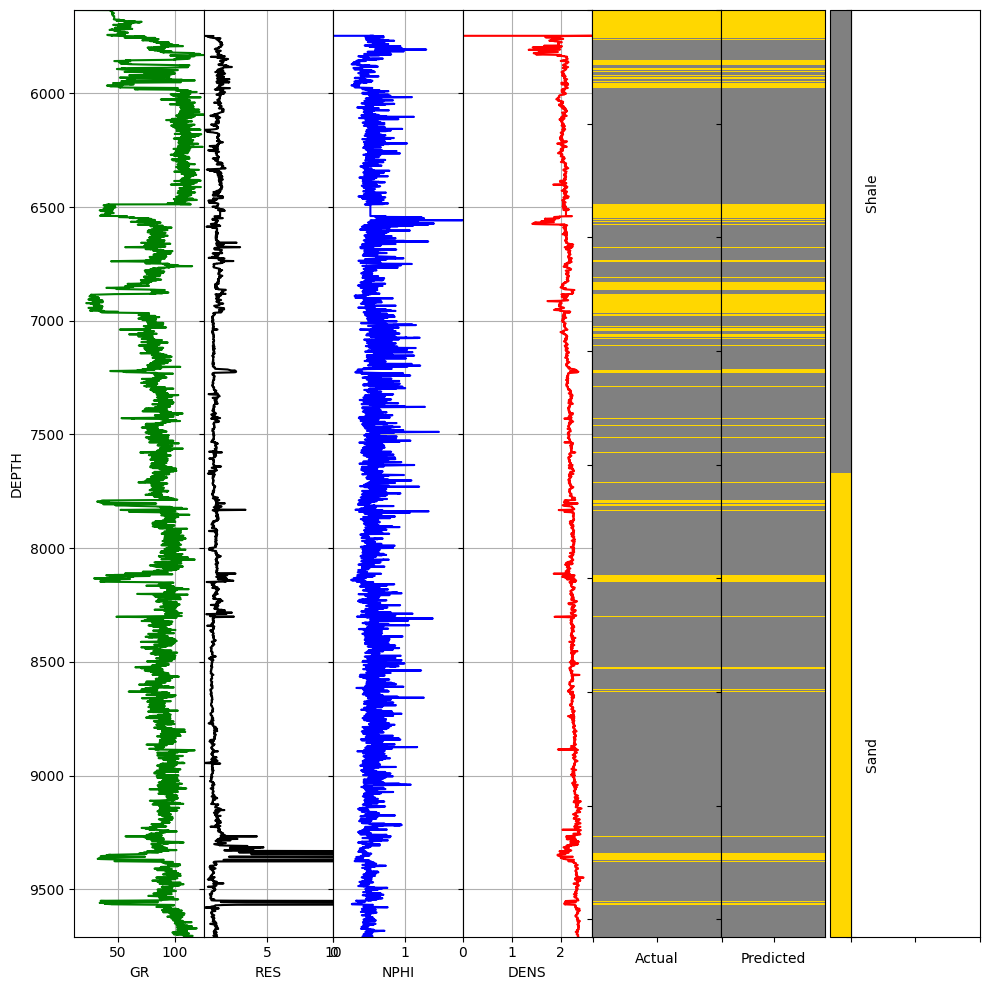

In [ ]:
freeman3st = df_copy[(ntrain-dropped_train): ((ntest_1-dropped_test_1) + (ntrain-dropped_train))]
freeman3st['PRED_LITHOLOGY'] = y_pred_1
# visulaize plot
compare_lithology_log_plot(freeman3st,'GR','RES','NPHI','DENS')

In [ ]:
## save the model
import joblib

joblib.dump(rfc,'work_2.pkl')

['work_2.pkl']

In [ ]:


#loaded_lith_model = pickle.load(open("lithology_pred_model_rfc.sav","rb"))

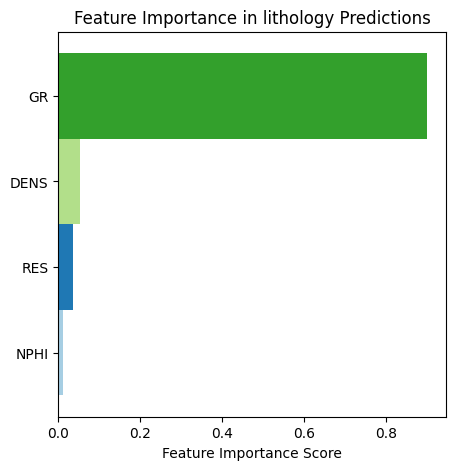

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in lithology Predictions')
plt.xlabel('Feature Importance Score');


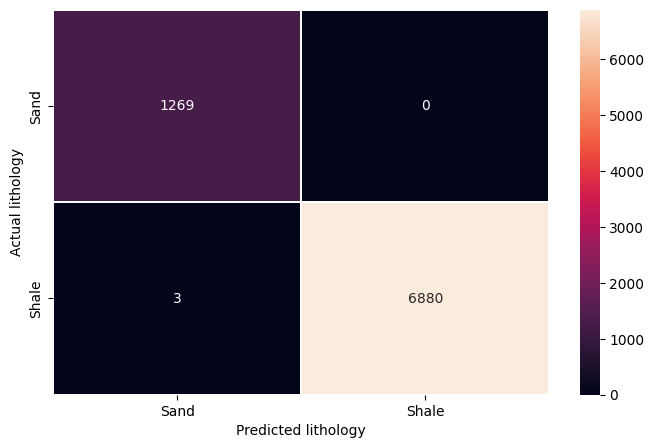

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_1, y_pred_1)

cf = pd.DataFrame(cf, index=['Sand', 'Shale'], columns=['Sand', 'Shale'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted lithology'); plt.ylabel('Actual lithology');

####XGBoostClassifier Model training

In [ ]:
X_train.shape, y_train.shape

((127453, 4), (127453,))

In [ ]:
import xgboost as xgb

class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))

## Instantiate xgboost classifier model
xgbc = xgb.XGBClassifier(n_estimators = 100,max_depth =5,class_weight = class_weights ,Objective ='binary:logistic', random_state=42)

## train the model
xgbc.fit(X_train,y_train)

XGBClassifier(Objective='binary:logistic', base_score=None, booster=None,
              callbacks=None, class_weight=array([1.54799961, 0.73854971]),
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [ ]:
# predicitions on the validation datsets

# Pearl 04
y_val_pred_1 = xgbc.predict(X_val_1)

# Ataga 07
y_val_pred_2 = xgbc.predict(X_val_2)

In [ ]:
# predictions on the test datasets

# Freeman 3st
y_pred_1 = xgbc.predict(X_test_1)

In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

acc_test_1 = accuracy_score(y_test_1,y_pred_1)
acc_val_1 = accuracy_score(y_val_1, y_val_pred_1)
acc_val_2 = accuracy_score(y_val_2, y_val_pred_2)

print("Accuracy score for Pearl 11 well: %.5f" % acc_val_1)
print("Accuracy score for Ataga 4 well: %.5f" % acc_val_2)
print('--------------------------------------')
print("Accuracy score for Freeman 3st well: %.5f" %acc_test_1)



classification_rep_4 = classification_report(y_val_1, y_val_pred_1)
classification_rep_5 = classification_report(y_val_2, y_val_pred_2)
classification_rep_1 = classification_report(y_test_1, y_pred_1)



print (classification_rep_1)
print("------------------------------------------------------")
print (classification_rep_4)
print (classification_rep_5)

Accuracy score for Pearl 11 well: 0.99857
Accuracy score for Ataga 4 well: 0.99980
--------------------------------------
Accuracy score for Freeman 3st well: 0.99828
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1269
           1       1.00      1.00      1.00      6883

    accuracy                           1.00      8152
   macro avg       0.99      1.00      1.00      8152
weighted avg       1.00      1.00      1.00      8152

------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6648
           1       1.00      1.00      1.00      4554

    accuracy                           1.00     11202
   macro avg       1.00      1.00      1.00     11202
weighted avg       1.00      1.00      1.00     11202

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3365
           1   

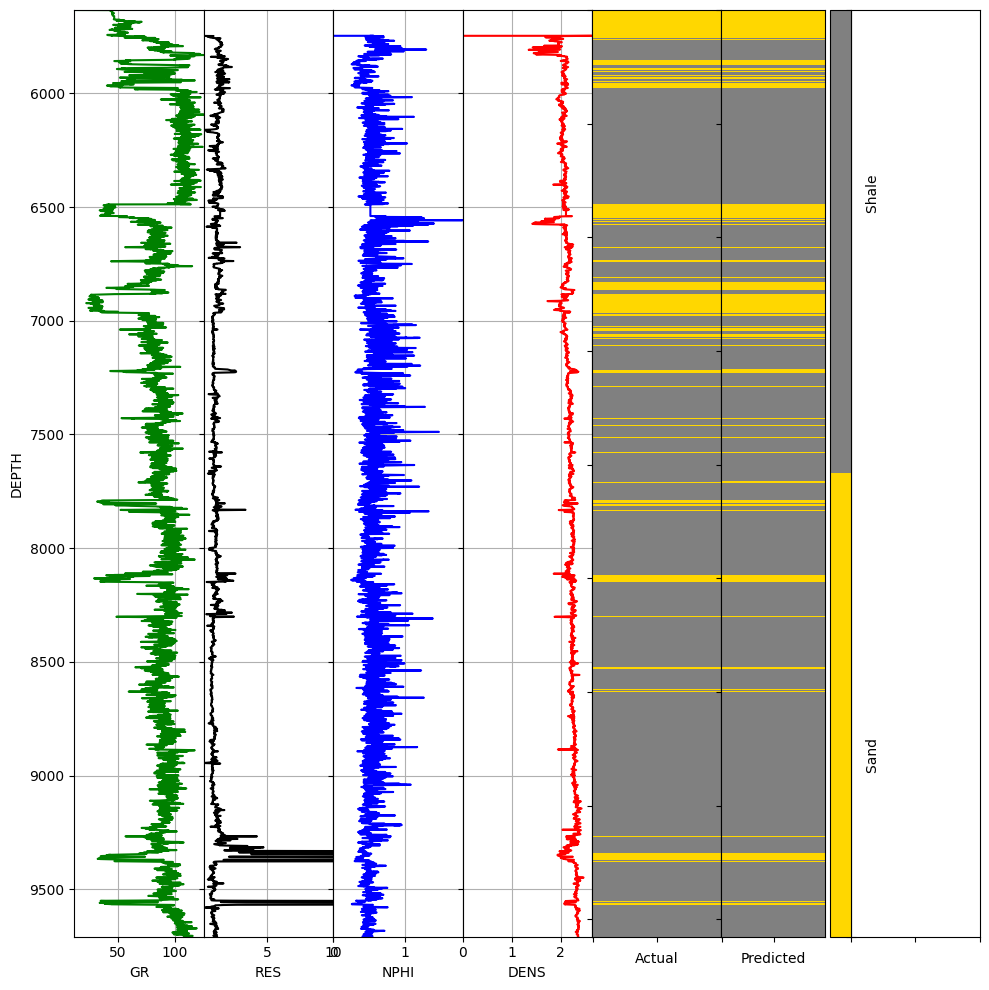

In [ ]:
freeman3st_1 = df_copy[(ntrain-dropped_train): ((ntest_1-dropped_test_1) + (ntrain-dropped_train))]
freeman3st_1['PRED_LITHOLOGY'] = y_pred_1
# visulaize plot
compare_lithology_log_plot(freeman3st_1,'GR','RES','NPHI','DENS')

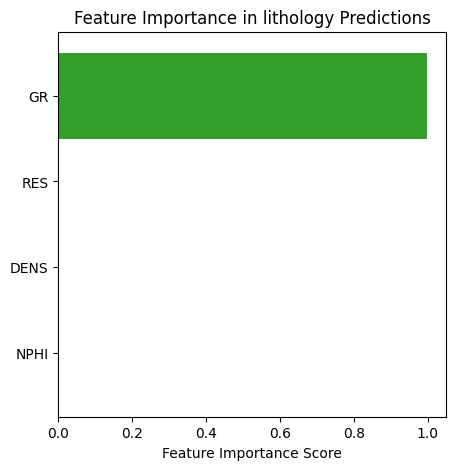

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(xgbc.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in lithology Predictions')
plt.xlabel('Feature Importance Score');


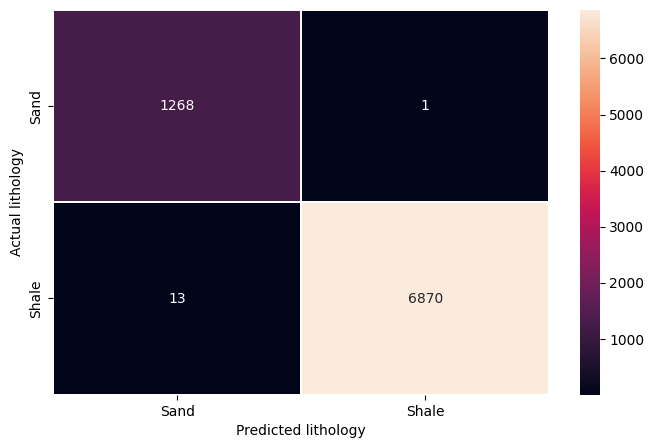

In [ ]:

## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_1, y_pred_1)

cf = pd.DataFrame(cf, index=['Sand', 'Shale'], columns=['Sand', 'Shale'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted lithology'); plt.ylabel('Actual lithology');

####CatboostClassifier model training

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
train_pool = Pool(X_train, label = y_train)
test_pool = Pool(X_test_1, label = y_test_1)

catboost_model = CatBoostClassifier(iterations = 500, depth=10, learning_rate=0.1, loss_function= 'Logloss')
catboost_model.fit(train_pool, eval_set= test_pool, early_stopping_rounds=50, verbose=100)

0:	learn: 0.3726679	test: 0.3576056	best: 0.3576056 (0)	total: 214ms	remaining: 1m 46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.00468628739
bestIteration = 25

Shrink model to first 26 iterations.


In [ ]:
# predicitions on the validation datsets

# Pearl 04
y_val_pred_1 = catboost_model.predict(X_val_1)

# Ataga 7
y_val_pred_2 = catboost_model.predict(X_val_2)

In [ ]:
# predictions on the test datasets

# Freeman 3st
y_pred_1 = catboost_model.predict(X_test_1)

In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

acc_test_1 = accuracy_score(y_test_1,y_pred_1)
acc_val_1 = accuracy_score(y_val_1, y_val_pred_1)
acc_val_2 = accuracy_score(y_val_2, y_val_pred_2)

print("Accuracy score for Pearl 04 well: %.5f" % acc_val_1)
print("Accuracy score for Ataga 7 well: %.5f" % acc_val_2)
print('--------------------------------------')
print("Accuracy score for Freeman 3st well: %.5f" %acc_test_1)



classification_rep_4 = classification_report(y_val_1, y_val_pred_1)
classification_rep_5 = classification_report(y_val_2, y_val_pred_2)
classification_rep_1 = classification_report(y_test_1, y_pred_1)



print (classification_rep_1)
print("------------------------------------------------------")
print (classification_rep_4)
print (classification_rep_5)

Accuracy score for Pearl 04 well: 0.99920
Accuracy score for Ataga 7 well: 0.99970
--------------------------------------
Accuracy score for Freeman 3st well: 0.99877
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1269
           1       1.00      1.00      1.00      6883

    accuracy                           1.00      8152
   macro avg       1.00      1.00      1.00      8152
weighted avg       1.00      1.00      1.00      8152

------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6648
           1       1.00      1.00      1.00      4554

    accuracy                           1.00     11202
   macro avg       1.00      1.00      1.00     11202
weighted avg       1.00      1.00      1.00     11202

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3365
           1   

##Freeman 05

In [ ]:
# concatenate pearl, Ataga, Test_3, Test_1
train_data = pd.concat ((Pearl,Ataga,Test_1,Test_3))
train_data = train_data.reset_index()
Test_2 = Test_2.reset_index()

In [ ]:
new_train_data = pd.concat((train_data,validation_data_1,validation_data_2)).drop_duplicates(keep=False)
print(f'Previous train data shape: {train_data.shape}')
print(f'New train data shape: {new_train_data.shape}')

Previous train data shape: (156442, 7)
New train data shape: (125218, 7)


In [ ]:
# check for data leakage
print (f'Original train data rows: {train_data.shape[0]}')
print (f'New_train + Validation rows: {new_train_data.shape[0] + validation_data_1.shape[0] + validation_data_2.shape[0]}')

Original train data rows: 156442
New_train + Validation rows: 156442


In [ ]:
# row numbers
ntrain = new_train_data.shape[0]
ntest_2 = Test_2.shape[0]

In [ ]:
## concatenating new_train_data, Test_2,and val 1 & 2 for combined cleaning
df = pd.concat((new_train_data,Test_2,validation_data_1,validation_data_2)).reset_index(drop=True)

In [ ]:
## Drop rows where LITHOLOGY is NAN
df = df.dropna(subset=['LITHOLOGY'])

In [ ]:
# Train_data
count_missing_lithology = pd.isna(new_train_data['LITHOLOGY']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")

Number of rows with missing values in LITHOLOGY: 216


In [ ]:
##Test 2
count_missing_lithology = pd.isna(Test_2['LITHOLOGY']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")

Number of rows with missing values in LITHOLOGY: 549


In [ ]:
dropped_train = 216
dropped_test_2 = 549

In [ ]:
## replace missing values in numerical variables with -999
df['DENS'] = df['DENS'].fillna(-999)
df['NPHI'] = df['NPHI'].fillna(-999)
df['RES'] = df['RES'].fillna(-999)

In [ ]:
df_copy = df.copy()

In [ ]:
## split back the df into train, test datasets
train = df_copy[:(ntrain-dropped_train)].copy()
train.drop(['LITHOLOGY'], axis=1, inplace=True)

test_2 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_2-dropped_test_2))].copy()
test_2.drop(['LITHOLOGY'],axis=1,inplace=True)
test_2 = test_2.reset_index(drop=True)

In [ ]:
# defining X_train and y_train
X_train = train.drop(columns=['DEPT','WELLNAME'], axis=1)
y_train = df_copy[:(ntrain-dropped_train)]['LITHOLOGY'].astype('int')

# defining X_test_2 and y_test_2
X_test_2 = test_2.drop(['DEPT',"WELLNAME"], axis=1)
y_test_2 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_2-dropped_test_2))]['LITHOLOGY'].astype('int')

####RandomForestClassifier model training

In [ ]:
# import model
from sklearn.ensemble import RandomForestClassifier

# initializing the model
rfc = RandomForestClassifier(n_estimators = 300, max_depth = 5, random_state=2023, verbose=2)

# fit the model to the data
rfc.fit(X_train,y_train)

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.9s


building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   13.5s


building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300


RandomForestClassifier(max_depth=5, n_estimators=300, random_state=2023,
                       verbose=2)

In [ ]:
# predictions on the test dataset

# Freeman 05
y_pred_2 = rfc.predict(X_test_2)


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score

acc_test_2 = accuracy_score(y_test_2,y_pred_2)
print ("Accuracy score for Freeman 05 well: %.5f" %acc_test_2)

Accuracy score for Freeman 05 well: 1.00000


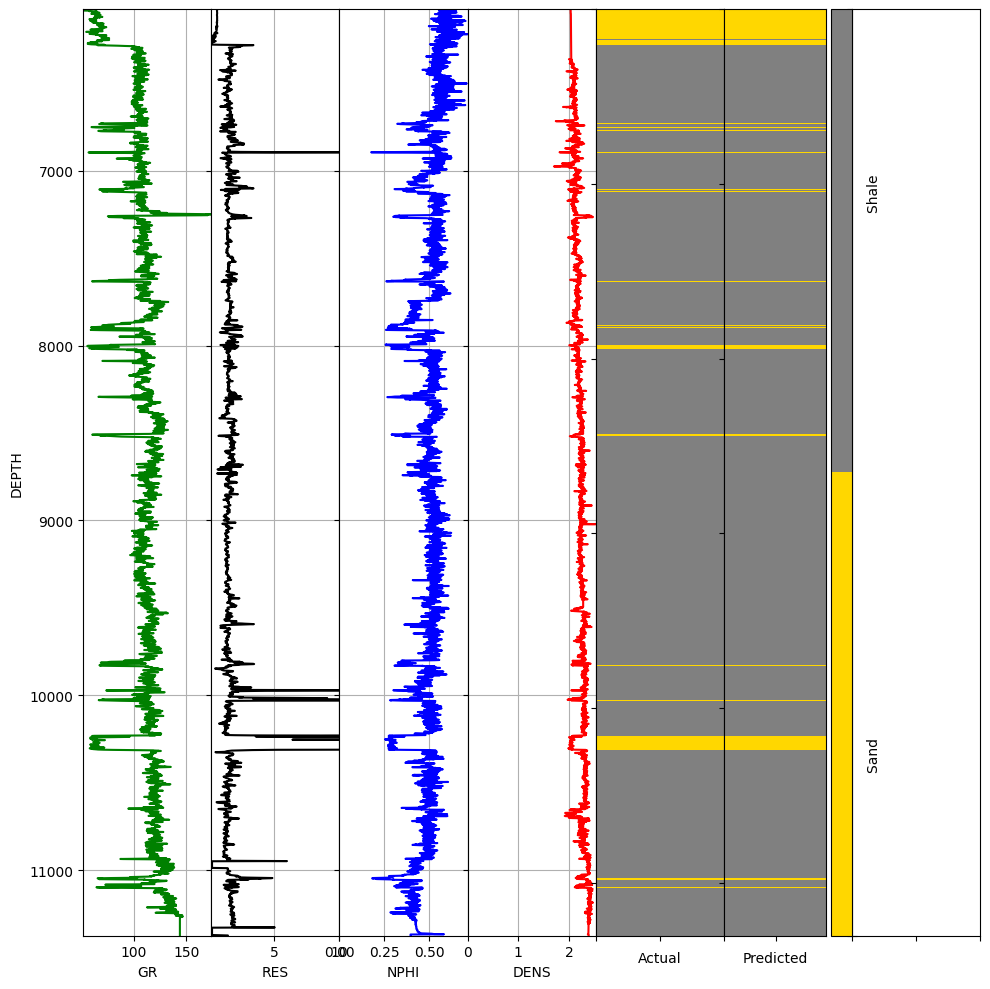

In [ ]:
freeman5 = df_copy[(ntrain-dropped_train): ((ntest_2-dropped_test_2) + (ntrain-dropped_train))]
freeman5['PRED_LITHOLOGY'] = y_pred_2
# visulaize plot
compare_lithology_log_plot(freeman5,'GR','RES','NPHI','DENS')

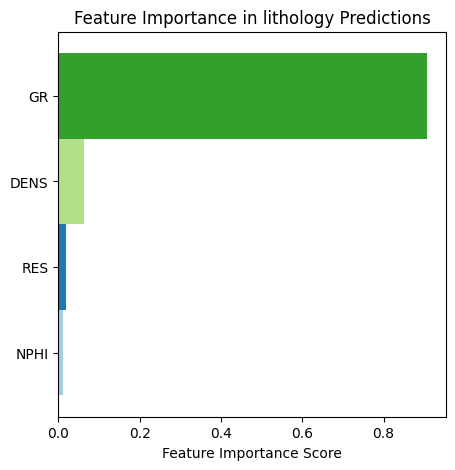

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in lithology Predictions')
plt.xlabel('Feature Importance Score');

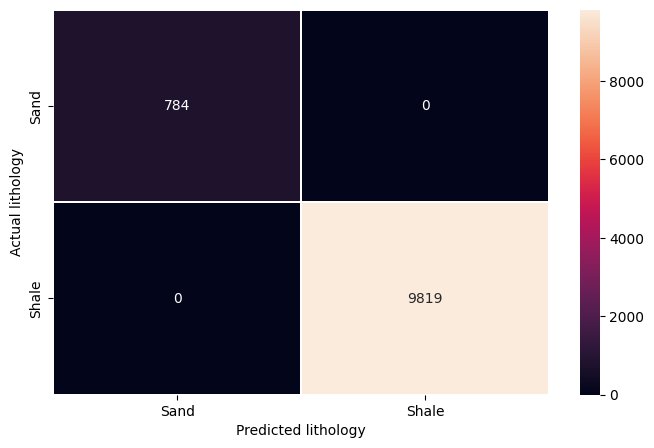

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_2, y_pred_2)

cf = pd.DataFrame(cf, index=['Sand', 'Shale'], columns=['Sand', 'Shale'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted lithology'); plt.ylabel('Actual lithology');

####XGBoostClassifier Model training

In [ ]:
import xgboost as xgb

## instantiate xgboost classifier model
xgbc = xgb.XGBClassifier(n_estimators = 100, Objective ='binary:logistic' , random_state=42)

## train the model
xgbc.fit(X_train,y_train)

XGBClassifier(Objective='binary:logistic', base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# predictions on the test datasets

# Freeman 05
y_pred_2 = xgbc.predict(X_test_2)

In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

acc_test_2 = accuracy_score(y_test_2,y_pred_2)


print("Accuracy score for Freeman 05 well: %.5f" %acc_test_2)
print("------------------------------------------------------")

classification_rep_2 = classification_report(y_test_2, y_pred_2)
print (classification_rep_2)

Accuracy score for Freeman 05 well: 0.99962
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       784
           1       1.00      1.00      1.00      9819

    accuracy                           1.00     10603
   macro avg       1.00      1.00      1.00     10603
weighted avg       1.00      1.00      1.00     10603



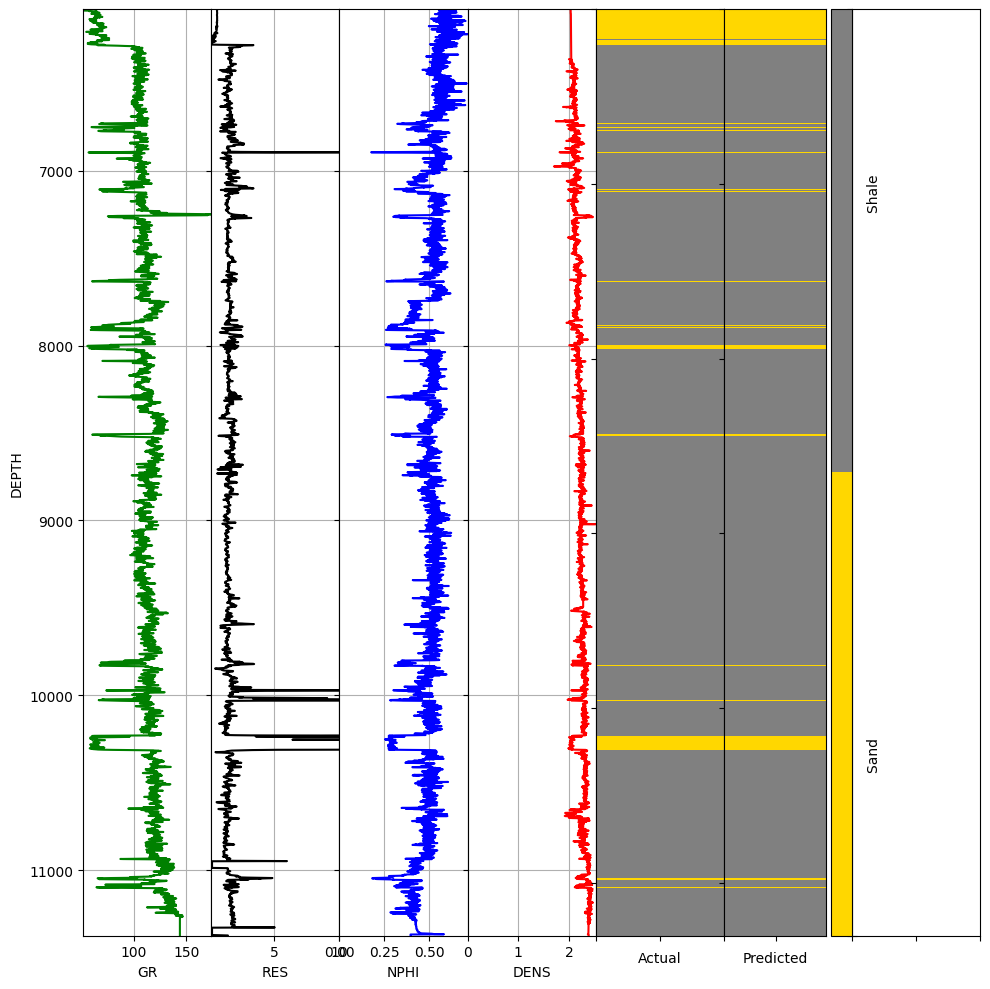

In [ ]:
freeman5 = df_copy[(ntrain-dropped_train): ((ntest_2-dropped_test_2) + (ntrain-dropped_train))]
freeman5['PRED_LITHOLOGY'] = y_pred_2
# visulaize plot
compare_lithology_log_plot(freeman5,'GR','RES','NPHI','DENS')

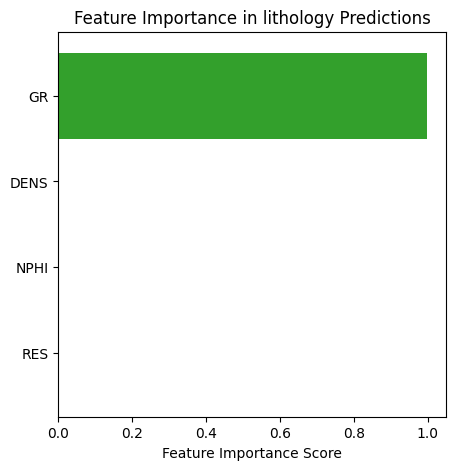

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(xgbc.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in lithology Predictions')
plt.xlabel('Feature Importance Score');

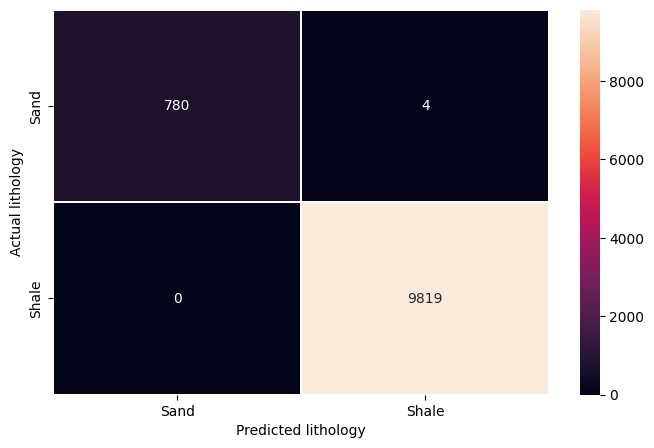

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_2, y_pred_2)

cf = pd.DataFrame(cf, index=['Sand', 'Shale'], columns=['Sand', 'Shale'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted lithology'); plt.ylabel('Actual lithology');

####CatboostClassifier model training

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
train_pool = Pool(X_train, label = y_train)
test_pool = Pool(X_test_2, label = y_test_2)

class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))

catboost_model = CatBoostClassifier(class_weights=class_weights,iterations = 200, depth=10, learning_rate=0.1, loss_function='Logloss')
catboost_model.fit(train_pool, eval_set= test_pool, early_stopping_rounds=50, verbose=100)

0:	learn: 0.3888169	test: 0.3618273	best: 0.3618273 (0)	total: 59ms	remaining: 11.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0006557479685
bestIteration = 38

Shrink model to first 39 iterations.


In [ ]:
# predictions on the test datasets

# Freeman 05
y_pred_2 = catboost_model.predict(X_test_2)

In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

acc_test_2 = accuracy_score(y_test_2,y_pred_2)

print("Accuracy score for Freeman 05 well: %.5f" %acc_test_2)
print('--------------------------------------')

classification_rep_2 = classification_report(y_test_2, y_pred_2)
print (classification_rep_2)


Accuracy score for Freeman 05 well: 0.99981
--------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       784
           1       1.00      1.00      1.00      9819

    accuracy                           1.00     10603
   macro avg       1.00      1.00      1.00     10603
weighted avg       1.00      1.00      1.00     10603



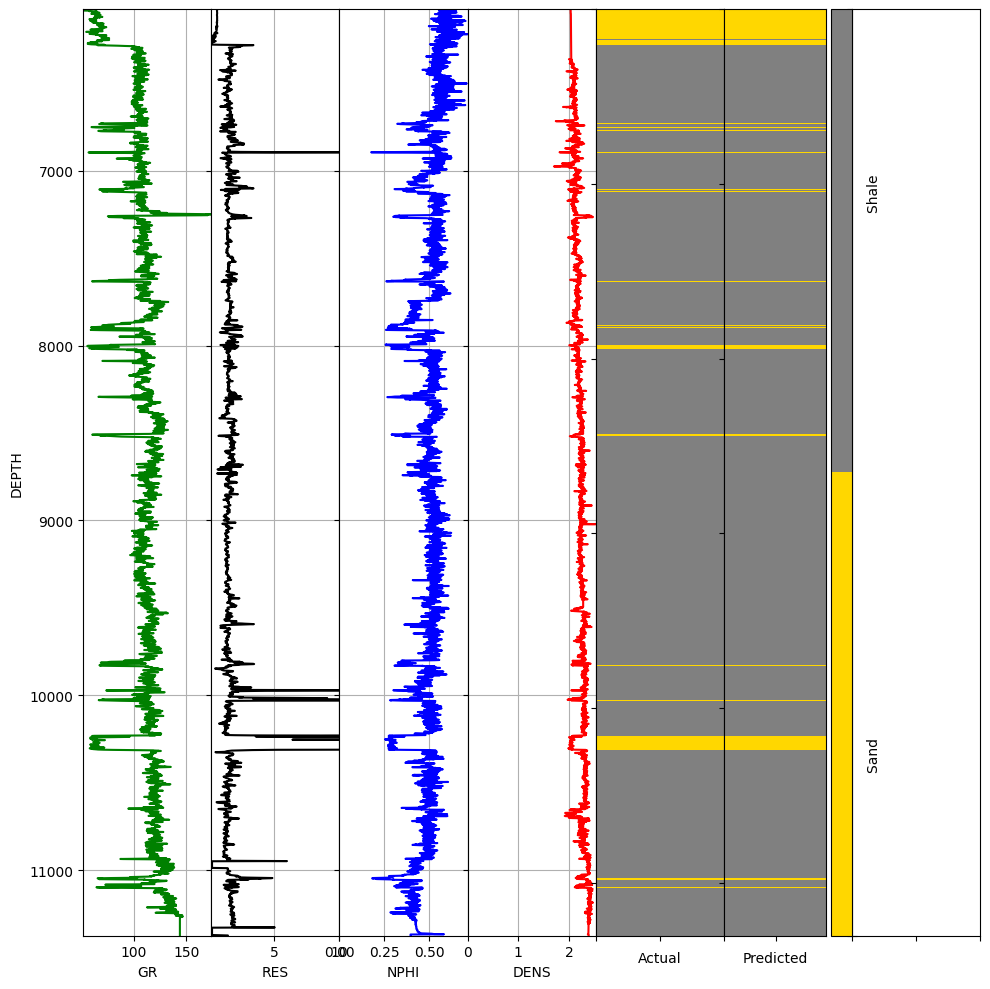

In [ ]:
freeman5_2 = df_copy[(ntrain-dropped_train): ((ntest_2-dropped_test_2) + (ntrain-dropped_train))]
freeman5_2['PRED_LITHOLOGY'] = y_pred_2
# visulaize plot
compare_lithology_log_plot(freeman5_2,'GR','RES','NPHI','DENS')

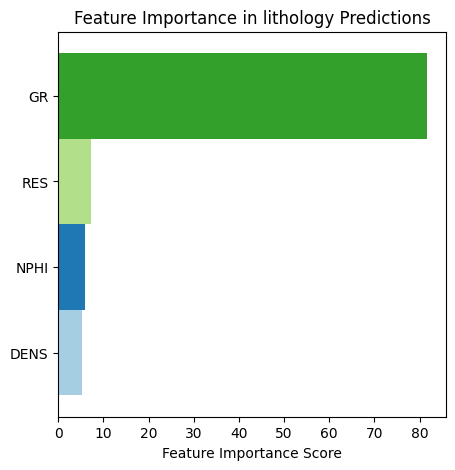

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(catboost_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in lithology Predictions')
plt.xlabel('Feature Importance Score');

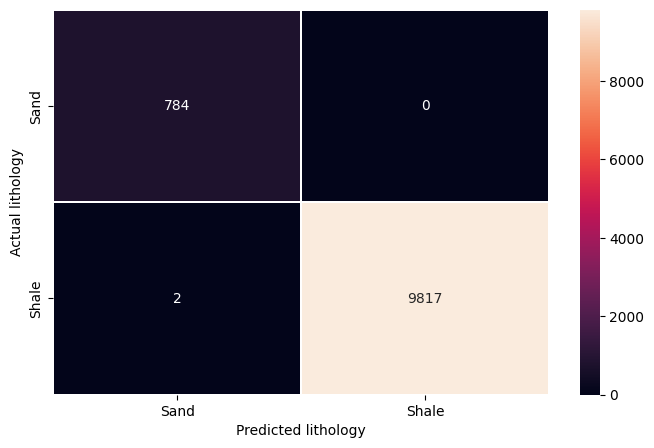

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_2, y_pred_2)

cf = pd.DataFrame(cf, index=['Sand', 'Shale'], columns=['Sand', 'Shale'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted lithology'); plt.ylabel('Actual lithology');

##Freeman 01

In [ ]:
# concatenate pearl, Ataga, Test_2, Test_1
train_data = pd.concat ((Pearl,Ataga,Test_1,Test_2))
train_data = train_data.reset_index()
Test_3 = Test_3.reset_index()

In [ ]:
new_train_data = pd.concat((train_data,validation_data_1,validation_data_2)).drop_duplicates(keep=False)
print(f'Previous train data shape: {train_data.shape}')
print(f'New train data shape: {new_train_data.shape}')

Previous train data shape: (147603, 7)
New train data shape: (116379, 7)


In [ ]:
# check for data leakage
print (f'Original train data rows: {train_data.shape[0]}')
print (f'New_train + Validation rows: {new_train_data.shape[0] + validation_data_1.shape[0] + validation_data_2.shape[0]}')

Original train data rows: 147603
New_train + Validation rows: 147603


In [ ]:
# row numbers
ntrain = new_train_data.shape[0]
ntest_3 = Test_3.shape[0]

In [ ]:
## concatenating new_train_data, Test_3,and val 1 & 2 for combined cleaning
df = pd.concat((new_train_data,Test_3,validation_data_1,validation_data_2)).reset_index(drop=True)

In [ ]:
## Drop rows where LITHOLOGY is NAN
df = df.dropna(subset=['LITHOLOGY'])

In [ ]:
# Train_data
count_missing_lithology = pd.isna(new_train_data['LITHOLOGY']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")

Number of rows with missing values in LITHOLOGY: 764


In [ ]:
##Test 3
count_missing_lithology = pd.isna(Test_3['LITHOLOGY']).sum()
print(f"Number of rows with missing values in LITHOLOGY: {count_missing_lithology}")

Number of rows with missing values in LITHOLOGY: 1


In [ ]:
dropped_train = 764
dropped_test_3 = 1

In [ ]:
## replace missing values in numerical variables with -999
df['DENS'] = df['DENS'].fillna(-999)
df['NPHI'] = df['NPHI'].fillna(-999)
df['RES'] = df['RES'].fillna(-999)

In [ ]:
df_copy = df.copy()

In [ ]:
## split back the df into train, test and val datasets
train = df_copy[:(ntrain-dropped_train)].copy()
train.drop(['LITHOLOGY'], axis=1, inplace=True)

test_3 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_3-dropped_test_3))].copy()
test_3.drop(['LITHOLOGY'],axis=1,inplace=True)
test_3 = test_3.reset_index(drop=True)

In [ ]:
# defining X_train and y_train
X_train = train.drop(['WELLNAME','DEPT'], axis=1)
y_train = df_copy[:(ntrain-dropped_train)]['LITHOLOGY'].astype('int')

# defining X_test_2 and y_test_2
X_test_3 = test_3.drop(["WELLNAME",'DEPT'], axis=1)
y_test_3 = df_copy[(ntrain-dropped_train): ((ntrain-dropped_train) + (ntest_3-dropped_test_3))]['LITHOLOGY'].astype('int')

####RandomForestClassifier model training

In [ ]:
# import model
from sklearn.ensemble import RandomForestClassifier

# initializing the model
rfc = RandomForestClassifier(n_estimators = 300, max_depth = 5, random_state=2023, verbose=2)

# fit the model to the data
rfc.fit(X_train,y_train)

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    2.6s


building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   12.4s


building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300
building tree 203 of 300
building tree 204 of 300


RandomForestClassifier(max_depth=5, n_estimators=300, random_state=2023,
                       verbose=2)

In [ ]:
# predictions on the test dataset

# Freeman 01
y_pred_3 = rfc.predict(X_test_3)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s


In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score

acc_test_3 = accuracy_score(y_test_3,y_pred_3)
print ("Accuracy score for Freeman 01 well: %.5f" %acc_test_3)

Accuracy score for Freeman 01 well: 0.99995


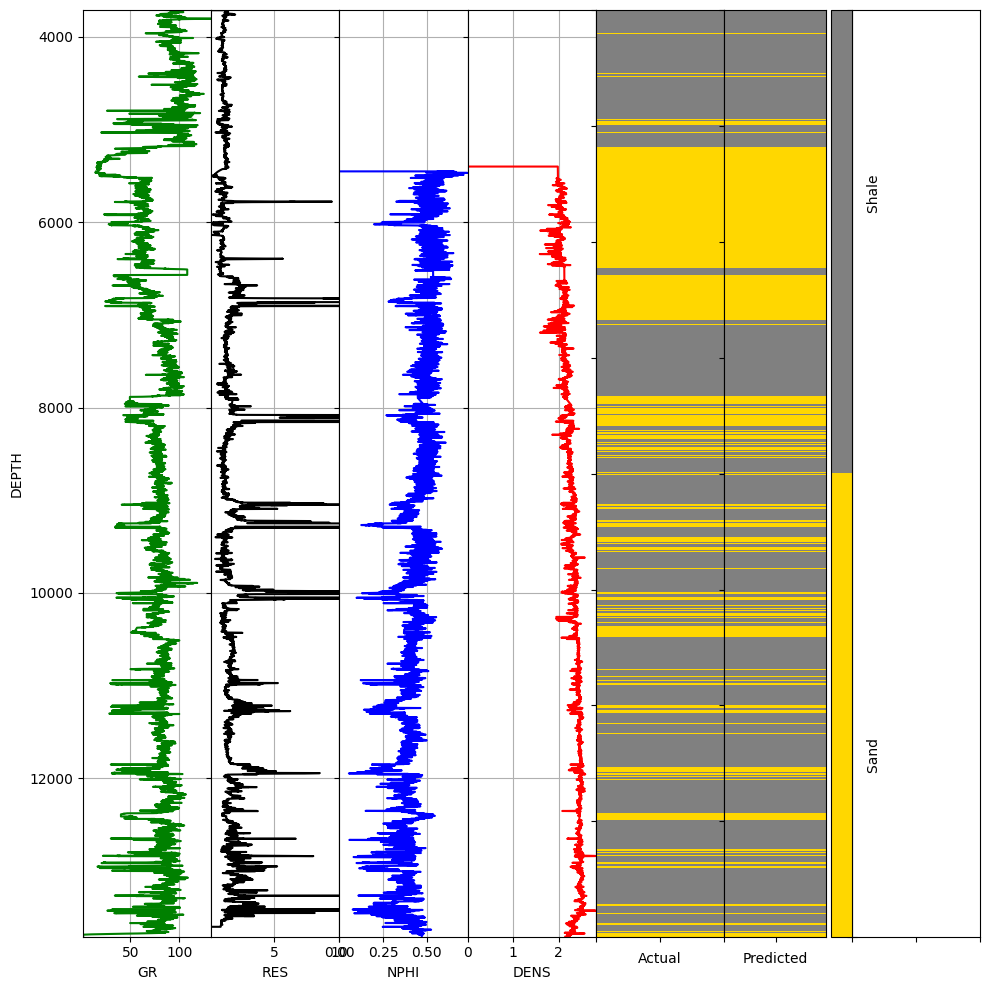

In [ ]:
freeman5_3 = df_copy[(ntrain-dropped_train): ((ntest_3-dropped_test_3) + (ntrain-dropped_train))]
freeman5_3['PRED_LITHOLOGY'] = y_pred_3
# visulaize plot
compare_lithology_log_plot(freeman5_3,'GR','RES','NPHI','DENS')

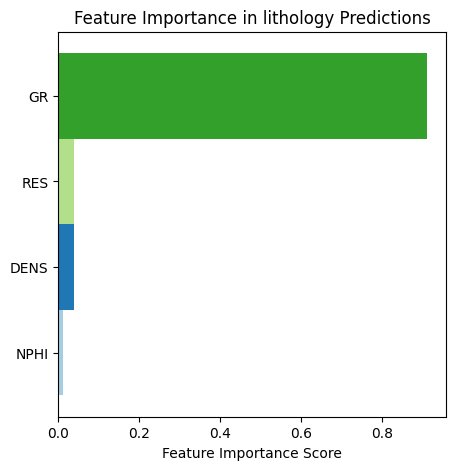

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in lithology Predictions')
plt.xlabel('Feature Importance Score');

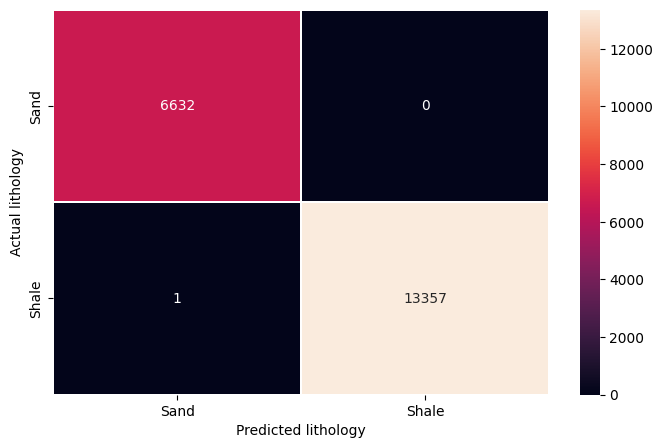

In [ ]:
## confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

#tuned_rfc model
cf = confusion_matrix(y_test_3, y_pred_3)

cf = pd.DataFrame(cf, index=['Sand', 'Shale'], columns=['Sand', 'Shale'])

plt.figure(figsize=(8, 5))
sns.heatmap(cf, annot=True, fmt='.0f', linewidth=0.01)
plt.xlabel('Predicted lithology'); plt.ylabel('Actual lithology');

####XGBoostClassifier Model training

In [ ]:
import xgboost as xgb

class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))

## instantiate xgboost classifier model
xgbc = xgb.XGBClassifier(n_estimators = 100, Objective = 'binary:logistic', random_state=42)

## train the model
xgbc.fit(X_train,y_train)

XGBClassifier(Objective='binary:logistic', base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# predictions on the test datasets

# Freeman 01
y_pred_3 = xgbc.predict(X_test_3)

In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


acc_test_3 = accuracy_score(y_test_3,y_pred_3)

print("Accuracy score for Freeman 01 well: %.5f" %acc_test_3)
print('-----------------------------------------------------------')

classification_rep_3 = classification_report(y_test_3, y_pred_3)
print (classification_rep_3)

Accuracy score for Freeman 01 well: 0.99685
-----------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6632
           1       1.00      1.00      1.00     13358

    accuracy                           1.00     19990
   macro avg       1.00      1.00      1.00     19990
weighted avg       1.00      1.00      1.00     19990



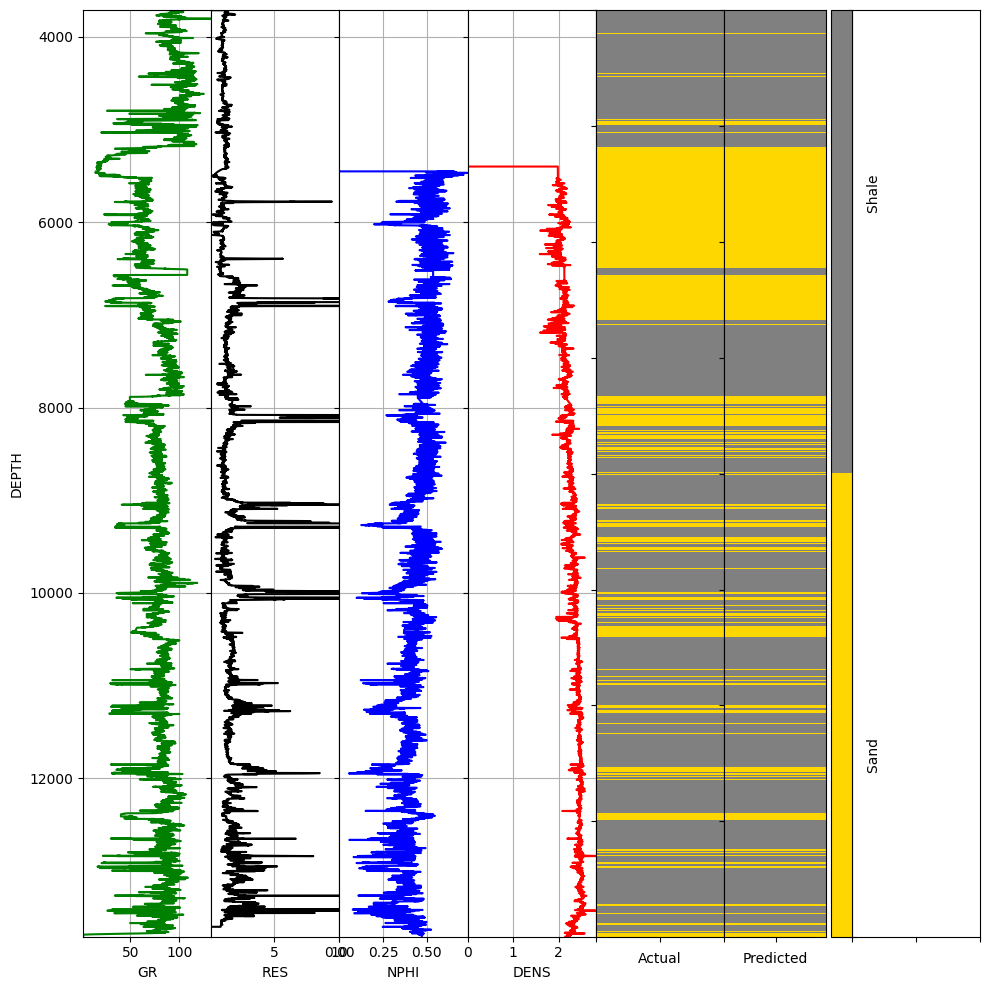

In [ ]:
freeman5_3 = df_copy[(ntrain-dropped_train): ((ntest_3-dropped_test_3) + (ntrain-dropped_train))]
freeman5_3['PRED_LITHOLOGY'] = y_pred_3
# visulaize plot
compare_lithology_log_plot(freeman5_3,'GR','RES','NPHI','DENS')

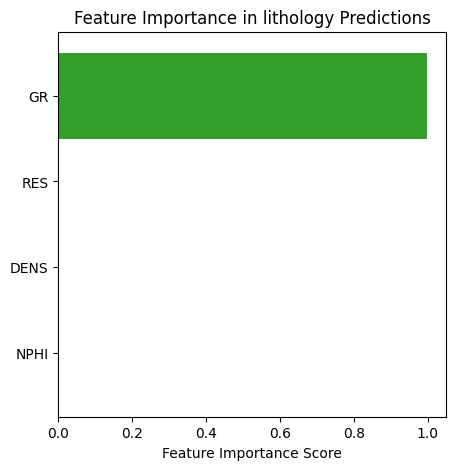

In [ ]:
## function to display feature importance of the predicitons
feat_imp = pd.Series(xgbc.feature_importances_, index=X_train.columns).sort_values(ascending=True)
plt.figure(figsize=(5,5))
feat_imp.plot(kind='barh',
    color=plt.cm.Paired(np.arange(len(feat_imp))),
    width=1,
    title='Feature Importance in lithology Predictions')
plt.xlabel('Feature Importance Score');

#### CatboostClassifier model training

In [ ]:
train_pool = Pool(X_train, label = y_train)
test_pool = Pool(X_test_3, label = y_test_3)

class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))

catboost_model = CatBoostClassifier(class_weights=class_weights,iterations = 500, depth=10, learning_rate=0.05, loss_function='Logloss')
catboost_model.fit(train_pool, eval_set= test_pool, early_stopping_rounds=50, verbose=100)

0:	learn: 0.5087769	test: 0.5080110	best: 0.5080110 (0)	total: 264ms	remaining: 2m 11s
100:	learn: 0.0010062	test: 0.0060706	best: 0.0060520 (67)	total: 10.3s	remaining: 40.8s
200:	learn: 0.0009036	test: 0.0060017	best: 0.0059508 (173)	total: 14.3s	remaining: 21.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.005950772464
bestIteration = 173

Shrink model to first 174 iterations.


In [ ]:
# predictions on the test datasets

# Freeman 01
y_pred_3 = catboost_model.predict(X_test_3)

In [ ]:
## Model Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

acc_test_3 = accuracy_score(y_test_3,y_pred_3)

print("Accuracy score for Freeman 01 well: %.5f" %acc_test_3)
print('--------------------------------------')

classification_rep_3 = classification_report(y_test_3, y_pred_3)
print (classification_rep_3)

Accuracy score for Freeman 01 well: 0.73458
--------------------------------------
              precision    recall  f1-score   support

           0       0.20      0.63      0.31      1202
           1       0.53      0.37      0.44      3700
           2       0.89      0.80      0.84     11284
           3       1.00      0.93      0.96      3737

    accuracy                           0.73     19923
   macro avg       0.66      0.68      0.64     19923
weighted avg       0.80      0.73      0.76     19923

